In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

import networkx as nx
from sklearn.cluster import KMeans
from sklearn import metrics

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
filename = 'dolphins.gml'
G_dolphins = nx.read_gml(filename)
B_dolphins = nx.modularity_matrix(G_dolphins)

In [3]:
B_dolphins.shape

(62, 62)

In [4]:
def givetrain(inputs,targets):  
  train_ds = TensorDataset(inputs, targets)
  train_dl=DataLoader(train_ds,batch_size=len(train_ds))
  return train_dl

In [5]:
class AE(nn.Module):
    def __init__(self,in_layers,hidden_layers):
        super().__init__()
        # Encoder
        self.encoder_hidden_layer = nn.Linear(
            in_features=in_layers, out_features=hidden_layers
        )
        self.encoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        # DEcoder
        self.decoder_hidden_layer= nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        self.decoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=in_layers
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.2)(activation)
        code = self.encoder_output_layer(activation)
        code = torch.tanh(code)
        # code = nn.Dropout(p=0.2)(code)
        encoder=code
        activation = self.decoder_hidden_layer(code)
        activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.2)(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.tanh(activation)
        # reconstructed = nn.Dropout(p=0.2)(reconstructed)
        return encoder,reconstructed

In [6]:
learning_rate = 1e-3

In [7]:
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model1 = AE(hidden_layers=32,in_layers=62)
model2=AE(hidden_layers=16,in_layers=32)
model3=AE(hidden_layers=8,in_layers=16)
# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)

# mean-squared error loss
def loss_func(input,target):
  return F.mse_loss(input,target)
print(model1)
print(model2)
print(model3)

AE(
  (encoder_hidden_layer): Linear(in_features=62, out_features=32, bias=True)
  (encoder_output_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_hidden_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_output_layer): Linear(in_features=32, out_features=62, bias=True)
)
AE(
  (encoder_hidden_layer): Linear(in_features=32, out_features=16, bias=True)
  (encoder_output_layer): Linear(in_features=16, out_features=16, bias=True)
  (decoder_hidden_layer): Linear(in_features=16, out_features=16, bias=True)
  (decoder_output_layer): Linear(in_features=16, out_features=32, bias=True)
)
AE(
  (encoder_hidden_layer): Linear(in_features=16, out_features=8, bias=True)
  (encoder_output_layer): Linear(in_features=8, out_features=8, bias=True)
  (decoder_hidden_layer): Linear(in_features=8, out_features=8, bias=True)
  (decoder_output_layer): Linear(in_features=8, out_features=16, bias=True)
)


In [8]:
def train_model(epochs,train_dl,model,optimizer,fl=0):
  enc,out=0,0
  hist=[]
  for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_dl:
      # reset the gradients back to zero
      # PyTorch accumulates gradients on subsequent backward passes
        # optimizer.zero_grad()
        optimizer.zero_grad()
        # compute reconstructions
        encoder,outputs = model(batch_features.float())
        # out=outputs
        if(fl==1):
          outputs=outputs.double()
        # compute training reconstruction loss
        train_loss = loss_func(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        enc=encoder
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        
        # enc=encoder  
    # compute the epoch training loss
    loss = loss / len(train_dl)
    hist.append(loss)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
  return(enc,hist)

In [9]:
B_dolphins=np.asarray(B_dolphins,dtype=np.float64)
inputs=torch.from_numpy(B_dolphins)
targets=torch.from_numpy(B_dolphins)

train_dl=givetrain(inputs,targets)

# AE 1 training
encoder,hist1=train_model(100,train_dl,model1,optimizer1,fl=1)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 2 training
encoder,hist2=train_model(300,train_dl,model2,optimizer2)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 3 training
# encoder,hist=train_model(200,train_dl,model3,optimizer3)
# train_dl=givetrain(encoder.detach(),encoder.detach())
# print(encoder)
# print(encoder.detach().shape)

epoch : 1/100, recon loss = 0.08646358
epoch : 2/100, recon loss = 0.08489520
epoch : 3/100, recon loss = 0.08343679
epoch : 4/100, recon loss = 0.08207809
epoch : 5/100, recon loss = 0.08080986
epoch : 6/100, recon loss = 0.07962341
epoch : 7/100, recon loss = 0.07851012
epoch : 8/100, recon loss = 0.07746170
epoch : 9/100, recon loss = 0.07647050
epoch : 10/100, recon loss = 0.07552950
epoch : 11/100, recon loss = 0.07463237
epoch : 12/100, recon loss = 0.07377345
epoch : 13/100, recon loss = 0.07294780
epoch : 14/100, recon loss = 0.07215114
epoch : 15/100, recon loss = 0.07137982
epoch : 16/100, recon loss = 0.07063072
epoch : 17/100, recon loss = 0.06990122
epoch : 18/100, recon loss = 0.06918909
epoch : 19/100, recon loss = 0.06849245
epoch : 20/100, recon loss = 0.06780969
epoch : 21/100, recon loss = 0.06713945
epoch : 22/100, recon loss = 0.06648056
epoch : 23/100, recon loss = 0.06583203
epoch : 24/100, recon loss = 0.06519300
epoch : 25/100, recon loss = 0.06456283
epoch : 2

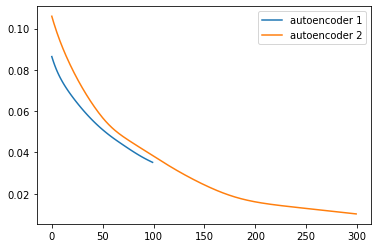

In [10]:
plt.plot(hist1,label='autoencoder 1')
plt.plot(hist2,label='autoencoder 2')
plt.legend()
plt.show()

In [11]:
B_dolphins_X=encoder.detach().numpy()

In [12]:
print(type(B_dolphins_X),B_dolphins_X)

<class 'numpy.ndarray'> [[-4.96698171e-01 -1.56818658e-01  1.28479198e-01 -2.56241411e-01
   8.58014151e-02  6.22070767e-03  1.80272803e-01 -2.98955500e-01
   4.63166356e-01 -5.69408238e-01 -1.45777419e-01 -2.44540036e-01
  -3.89959425e-01 -3.31626326e-01  2.36460585e-02  5.21461785e-01]
 [ 4.23624635e-01 -7.47586489e-01  7.31999516e-01 -4.68461245e-01
  -2.14522034e-01  4.93634082e-02 -1.93683669e-01  3.87406409e-01
   1.19217016e-01 -3.66974741e-01  4.40076500e-01  5.50949752e-01
   5.91363788e-01 -4.40492392e-01 -5.35781980e-01 -2.10481212e-01]
 [-2.80935109e-01 -1.84251100e-01  3.15310478e-01 -2.20609829e-01
  -5.78497797e-02 -3.02418917e-02  5.88043779e-02 -5.22909090e-02
   2.47866467e-01 -4.27265048e-01 -2.03450054e-01 -6.30297512e-02
  -1.81904003e-01 -1.89712524e-01 -1.46516398e-01  7.79462978e-02]
 [-5.01044393e-01  2.81397533e-02  4.61870283e-01 -1.02812797e-01
  -4.98714834e-01 -2.72363394e-01 -8.56350642e-03  3.10365539e-02
   8.39765221e-02 -3.89223605e-01 -5.58155537e-01

In [15]:
kmeans = KMeans(init='k-means++',n_clusters=4,random_state=605)
kmeans.fit(B_dolphins_X)
X_ae = kmeans.labels_
#---------------------------------------------------------|Ground Truth|-------
c_attributes = nx.get_node_attributes(G_dolphins,'value')
c_groups = []

for i, val in enumerate(c_attributes.values()):
    c_groups.append(val)
        
X_gt = np.array(c_groups)
print(X_ae)
print(X_gt)
metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')

[1 0 2 2 3 0 0 0 1 0 1 3 2 0 2 3 2 0 3 0 2 3 0 3 3 0 0 0 1 3 1 0 0 2 2 3 0
 2 2 2 2 0 1 2 2 3 2 1 0 2 2 3 2 2 0 3 0 0 2 2 0 1]
[1 0 1 2 3 0 0 0 2 0 1 3 2 0 2 3 2 0 3 0 2 3 0 3 3 0 0 0 1 3 1 0 0 2 2 3 2
 2 2 2 2 0 1 2 2 3 2 1 0 2 2 3 2 2 0 3 0 0 2 2 0 2]


0.8380828027527368

In [14]:
max=0
index_max=0
for value in range(1,1000):
    kmeans = KMeans(init='k-means++',n_clusters=4,random_state=value)
    kmeans.fit(B_dolphins_X)
    X_ae = kmeans.labels_

    c_groups=[]
    c_attributes = nx.get_node_attributes(G_dolphins,'value')
    for i, val in enumerate(c_attributes.values()):
        c_groups.append(val)
            
    X_gt = np.array(c_groups)
    temp=metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')
    if(temp>max):
        max=temp
        index_max=value
    print("Epoch:{}".format(value),index_max,max)

Epoch:1 1 0.5107988300456398
Epoch:2 2 0.5399117554067465
Epoch:3 3 0.8142962788071175
Epoch:4 3 0.8142962788071175
Epoch:5 3 0.8142962788071175
Epoch:6 3 0.8142962788071175
Epoch:7 3 0.8142962788071175
Epoch:8 3 0.8142962788071175
Epoch:9 3 0.8142962788071175
Epoch:10 3 0.8142962788071175
Epoch:11 3 0.8142962788071175
Epoch:12 3 0.8142962788071175
Epoch:13 3 0.8142962788071175
Epoch:14 3 0.8142962788071175
Epoch:15 3 0.8142962788071175
Epoch:16 3 0.8142962788071175
Epoch:17 3 0.8142962788071175
Epoch:18 3 0.8142962788071175
Epoch:19 3 0.8142962788071175
Epoch:20 3 0.8142962788071175
Epoch:21 3 0.8142962788071175
Epoch:22 3 0.8142962788071175
Epoch:23 3 0.8142962788071175
Epoch:24 3 0.8142962788071175
Epoch:25 3 0.8142962788071175
Epoch:26 3 0.8142962788071175
Epoch:27 3 0.8142962788071175
Epoch:28 3 0.8142962788071175
Epoch:29 3 0.8142962788071175
Epoch:30 3 0.8142962788071175
Epoch:31 3 0.8142962788071175
Epoch:32 3 0.8142962788071175
Epoch:33 3 0.8142962788071175
Epoch:34 3 0.814296